In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp, cumtrapz
from scipy.stats import truncnorm

from models import *

%load_ext autoreload
%autoreload 2

# Experimental Data Cleaning

To apply data-driven kinetics modeling directly to experimental data, we must clean the data. Specifically, we need to:
* Eliminate errors in effluence data at the beginning and end of the experiment (e.g. from turning gas on and off)
* Correct for baseline shift in the oxygen concentration meter
* Interpolate onto common grid of time points

Below, we implement these steps and generate figures showing the process.

In [2]:
oil_type, experiment = 'chichimene', '0 PSI'
hr = '2'
expdirname = os.path.join('datasets', oil_type, experiment)

df = pd.read_excel(os.path.join(expdirname, hr+'C_min.xls'))

INTERPNUM = 300

# Read in data
Time = df.Time.values
O2 = df.O2.values
Temp = df.Temperature.values

ind100C = np.amin(np.asarray(Temp > 100).nonzero())
ind200C = np.amin(np.asarray(Temp > 180).nonzero())
inds750 = np.asarray(Temp > 745).nonzero()[0]
ind750C1 = inds750[np.round(0.75*inds750.shape[0]).astype(int)]
ind750C2 = inds750[np.round(0.9*inds750.shape[0]).astype(int)]

# Gather datapoints and perform linear regression correction
correction_times = np.concatenate([Time[ind100C:ind200C+1], Time[ind750C1:ind750C2+1]])
correction_O2s = np.concatenate([O2[ind100C:ind200C+1], O2[ind750C1:ind750C2+1]])
slope, intercept, _, _, _ = linregress(correction_times, correction_O2s)
O2_baseline = slope*Time + intercept

# Calculate %O2 consumption and conversion
O2_consumption = np.maximum(O2_baseline - O2, 0)
O2_consumption[:ind200C] = 0 # zero out non-reactive regions
O2_consumption[ind750C1:] = 0
O2_conversion = cumtrapz(O2_consumption, x=Time, initial=0)
O2_conversion /= O2_conversion[-1]
dO2_conversion = np.gradient(O2_conversion, Time/60)



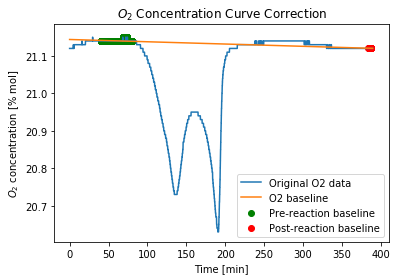

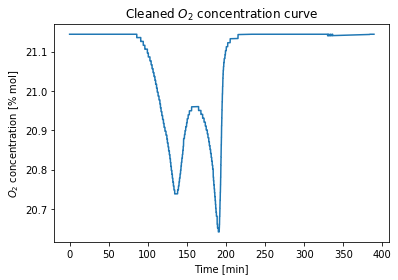

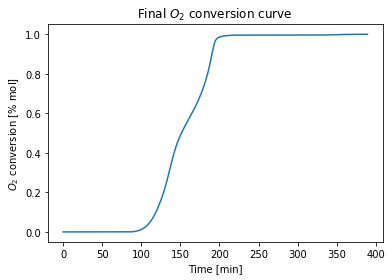

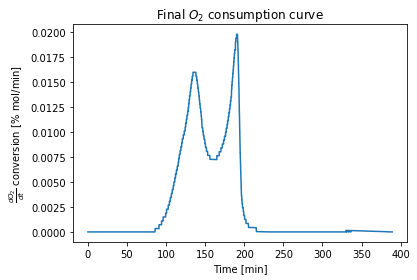

In [4]:
plt.plot(Time/60, O2)
plt.plot(Time/60, O2_baseline)
plt.scatter(Time[ind100C:ind200C+1]/60, O2[ind100C:ind200C+1],color='g')
plt.scatter(Time[ind750C1:ind750C2+1]/60, O2[ind750C1:ind750C2+1],color='r')
plt.xlabel('Time [min]')
plt.ylabel(r'$O_2$ concentration [% mol]')
plt.title(r'$O_2$ Concentration Curve Correction')
plt.legend(['Original O2 data', 'O2 baseline', 'Pre-reaction baseline', 'Post-reaction baseline'])
plt.savefig(os.path.join('results', 'data_cleaning','O2_concentration_original.png'))
plt.show()

plt.plot(Time/60, O2_baseline[0] - O2_consumption)
plt.xlabel('Time [min]')
plt.ylabel(r'$O_2$ concentration [% mol]')
plt.title(r'Cleaned $O_2$ concentration curve')
plt.savefig(os.path.join('results', 'data_cleaning','O2_concentration_cleaned.png'))
plt.show()

plt.plot(Time/60, O2_conversion)
plt.xlabel('Time [min]')
plt.ylabel(r'$O_2$ conversion [% mol]')
plt.title(r'Final $O_2$ conversion curve')
plt.savefig(os.path.join('results', 'data_cleaning','O2_conversion.png'))
plt.show()

plt.plot(Time/60, dO2_conversion)
plt.xlabel('Time [min]')
plt.ylabel(r'$\frac{dO_2}{dt}$ conversion [% mol/min]')
plt.title(r'Final $O_2$ consumption curve')
plt.savefig(os.path.join('results', 'data_cleaning','O2_consumption.png'))
plt.show()


# Comparison of Heavy Oil Combustion at Atmospheric Pressure

We compare Chichimene and Xinjiang heavy oil samples for RTO experiments performed at atmospheric pressure.

In [26]:
# Front matter
result_dir = os.path.join('results', 'heavy_oil_comp_0PSI') 
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

VMIN_s=0.0
VMAX_s = 0.45

VMIN_u = -9.5
VMAX_u = -3.75

Minimum conversion rate: -6.898579194710664e-17, maximum conversion rate: 0.11999255616626948


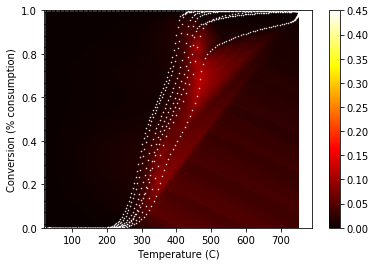

Minimum conversion rate: -0.0004678484808386442, maximum conversion rate: 0.4335505840813001


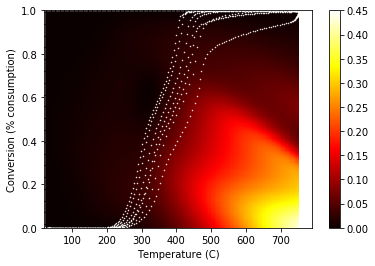

Minimum log-std. dev.: -8.364402005934327, maximum log-std. dev.: -3.86325288581108


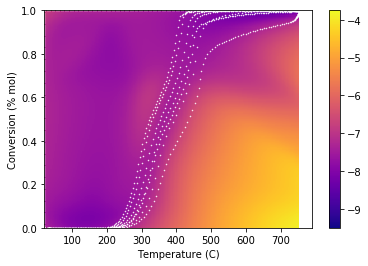

Minimum conversion rate: 0.0, maximum conversion rate: 0.4335505840813001


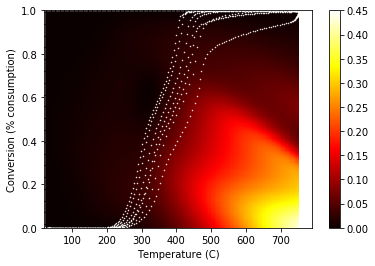

Minimum log-std. dev.: -8.788154441699009, maximum log-std. dev.: -3.863385525929831


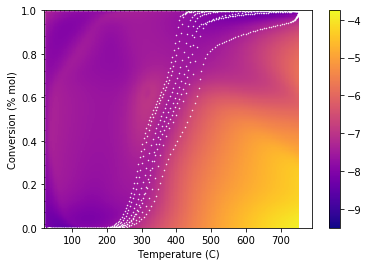

In [27]:
### CHICHIMENE DATA

# Interpolation model
nainterp = NonArrheniusInterp(oil_type='chichimene', experiment='0 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_interp_conrate.png'),vmin=VMIN_s,vmax=VMAX_s)

# Unconstrained NAMLA model
naml1 = NonArrheniusML(oil_type='chichimene',experiment='0 PSI', interpnum=200)
naml1.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='chichimene',experiment='0 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_cnamla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_cnamla.png'),vmin=VMIN_u,vmax=VMAX_u)



Minimum conversion rate: -1.6680846012548097e-17, maximum conversion rate: 0.07059405260939866


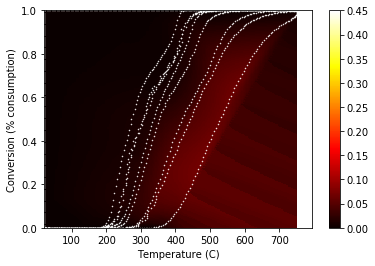

Minimum conversion rate: -0.00031465149258797637, maximum conversion rate: 0.14764044421110106


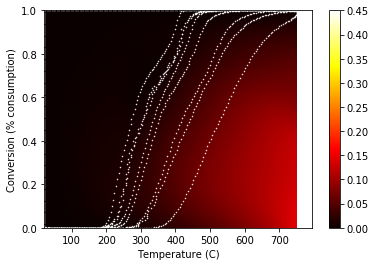

Minimum log-std. dev.: -8.97807524943971, maximum log-std. dev.: -5.247161121339271


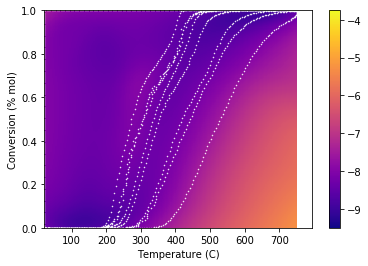

Minimum conversion rate: 0.0, maximum conversion rate: 0.14764044421110106


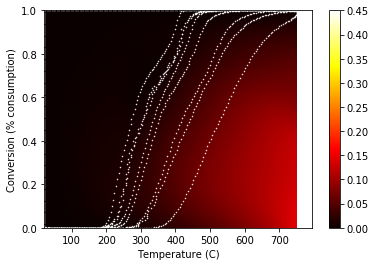

Minimum log-std. dev.: -9.444958395918562, maximum log-std. dev.: -5.2474715909680105


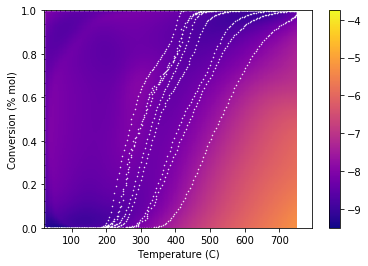

In [28]:
### XINJIANG DATA

# Interpolation model
nainterp = NonArrheniusInterp(oil_type='xinjiang', experiment='0 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'xinjiang_interp_conrate.png'),vmin=VMIN_s,vmax=VMAX_s)

# Unconstrained NAMLA model
naml1 = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI', interpnum=200)
naml1.print_surf_plot(save_path = os.path.join(result_dir, 'xinjiang_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'xinjiang_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'xinjiang_conrate_cnamla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'xinjiang_uncertainty_cnamla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Comparison of Heavy Oil Combustion at 100 PSI

We compare Chichimene and Tekel heavy oil samples for RTO experiments performed at 100 PSI.

In [29]:
# Frontmatter
result_dir = os.path.join('results', 'heavy_oil_comp_100PSI') 
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
VMIN_s = 0.0
VMAX_s = 0.15

VMIN_u = -10.2
VMAX_u = -5.0

Minimum conversion rate: -8.405524431700351e-17, maximum conversion rate: 0.10397338563451716


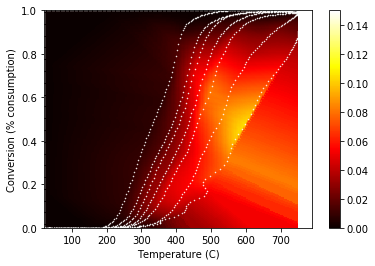

Minimum conversion rate: -0.0012889388935525222, maximum conversion rate: 0.1442337840370045


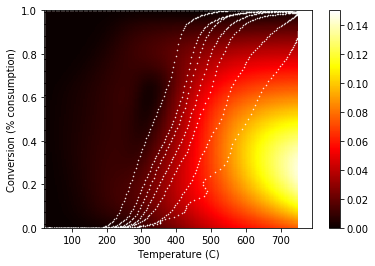

Minimum log-std. dev.: -8.891425885204306, maximum log-std. dev.: -5.015812184364471


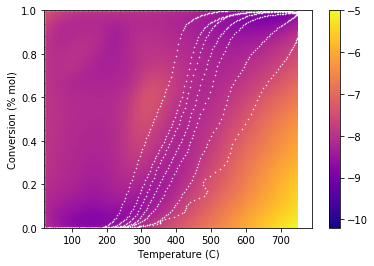

Minimum conversion rate: 0.0, maximum conversion rate: 0.1442337840370045


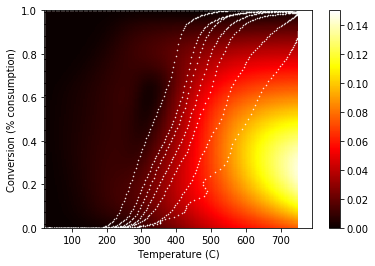

Minimum log-std. dev.: -10.086764675233963, maximum log-std. dev.: -5.0183875784569985


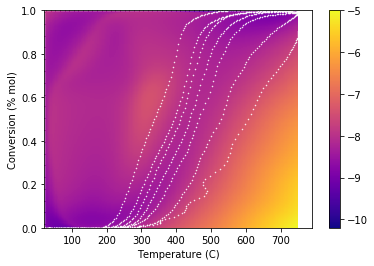

In [30]:
### CHICHIMENE DATA

# Interpolation model
nainterp = NonArrheniusInterp(oil_type='chichimene', experiment='100 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_interp_conrate.png'),vmin=VMIN_s,vmax=VMAX_s)

# Unconstrained NAMLA model
naml1 = NonArrheniusML(oil_type='chichimene', experiment='100 PSI', interpnum=200)
naml1.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='chichimene', experiment='100 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_cnamla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_cnamla.png'),vmin=VMIN_u,vmax=VMAX_u)

Minimum conversion rate: -1.2225146983897867e-16, maximum conversion rate: 0.1018530679104891


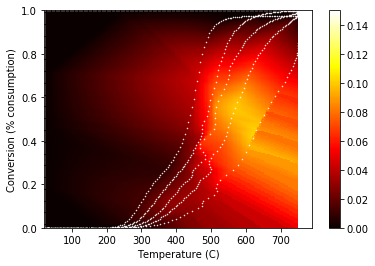

Minimum conversion rate: -0.0013160072383796302, maximum conversion rate: 0.12232262638933433


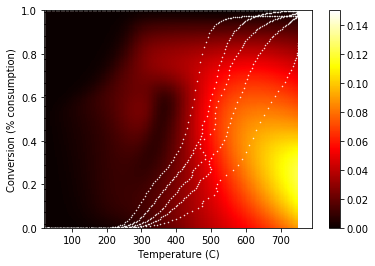

Minimum log-std. dev.: -8.647842296106495, maximum log-std. dev.: -5.205331641031744


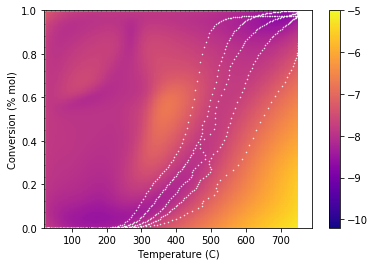

Minimum conversion rate: 0.0, maximum conversion rate: 0.12232262638933433


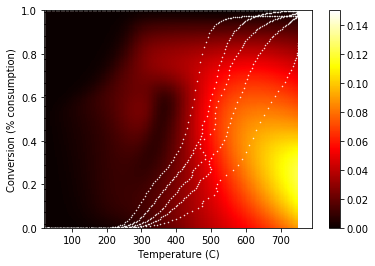

Minimum log-std. dev.: -9.708118957219792, maximum log-std. dev.: -5.207250934138105


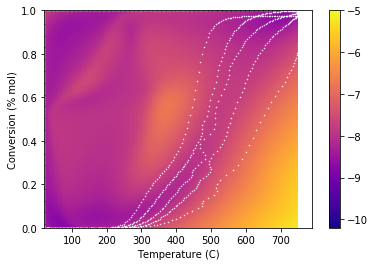

In [31]:
### TEKEL DATA

# Interpolation model
nainterp = NonArrheniusInterp(oil_type='tekel', experiment='100 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'tekel_interp_conrate.png'),vmin=VMIN_s,vmax=VMAX_s)

# Unconstrained NAMLA model
naml1 = NonArrheniusML(oil_type='tekel', experiment='100 PSI', interpnum=200)
naml1.print_surf_plot(save_path = os.path.join(result_dir, 'tekel_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'tekel_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='tekel', experiment='100 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'tekel_conrate_cnamla.png'),vmin=VMIN_s,vmax=VMAX_s)
naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'tekel_uncertainty_cnamla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Simulation Example - Comparison to Experimental Data
Compare data from 3 C/min and 20 C/min for Xinjiang sample. Both tested heating rates are held-out from the predictive models in both cases. 

In [32]:
# Load data
training_heating_rates = ['1.5C_min', '2C_min', '2.5C_min', '5C_min', '10C_min', '15C_min']
nainterp = NonArrheniusInterp(oil_type='xinjiang',experiment='0 PSI',heating_rates=training_heating_rates)
naml_unc = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI',heating_rates=training_heating_rates)
naml_const = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI',heating_rates=training_heating_rates)


20C_min


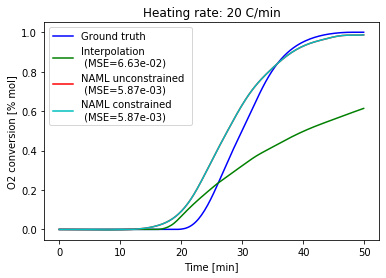

5C_min


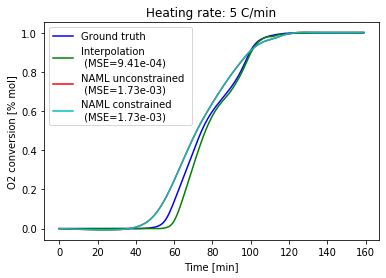

In [33]:
# Load data
test_heating_rates = ['20C_min', '5C_min']
titles=['20 C/min', '5 C/min']
data_container = NonArrheniusInterp(oil_type='xinjiang', experiment='0 PSI', heating_rates = test_heating_rates)

for i, hr in enumerate(data_container.heating_rates):
    print(hr)
    Time = data_container.Times[i,:]/60
    Temp = data_container.Temps[i,:]
    O2 = data_container.O2convs[i,:]
    
    
    plt.plot(Time, O2, 'b')
    plt.xlabel('Time [min]')
    plt.ylabel('O2 conversion [% mol]')
    plt.title('Heating rate: {}'.format(titles[i]))
    
    y0=[0.0]
    tspan=[Time[0], Time[-1]]
    heating=[Time, Temp]
    t_interp, y_interp = nainterp.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
    plt.plot(t_interp, np.squeeze(y_interp),'g')
    MSE_interp = np.mean((O2 - np.interp(Time, t_interp, np.squeeze(y_interp)))**2)
    
    t_ml, y_ml = naml_unc.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
    plt.plot(t_ml, np.squeeze(y_ml),'r')
    MSE_ml = np.mean((O2 - np.interp(Time, t_ml, np.squeeze(y_ml)))**2)
    
    t_mlc, y_mlc = naml_const.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
    plt.plot(t_mlc, np.squeeze(y_mlc),'c')
    MSE_mlc = np.mean((O2 - np.interp(Time, t_mlc, np.squeeze(y_mlc)))**2)
    
    plt.legend(['Ground truth', 'Interpolation \n (MSE={0:.2e})'.format(MSE_interp), \
                'NAML unconstrained \n (MSE={0:.2e})'.format(MSE_ml), 'NAML constrained \n (MSE={0:.2e})'.format(MSE_mlc)])
    plt.savefig(os.path.join('results','data_simulation_plots','hr{}.png'.format(hr)))
    plt.show()



# Simulation Example - Nonlinear Heating

Show simulation of non-linear heating rate on Xinjiang oil data and add uncertainty bounds. 

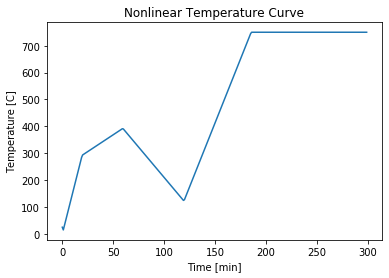

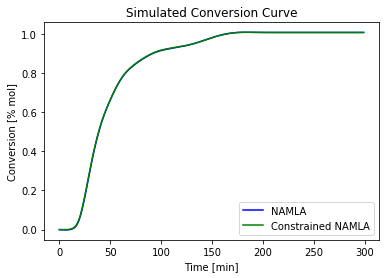

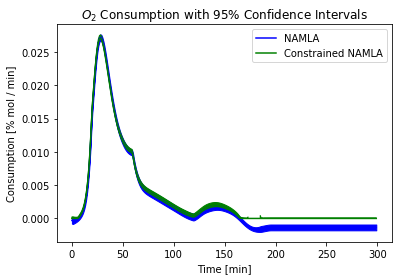

In [24]:
# Create heating ramp
Time = np.arange(0,300,1)
hrs = np.asarray([15.0]*20 + [2.5]*40 + [-4.5]*60 + [9.5]*180)
Temp = np.minimum(cumtrapz(hrs, Time, initial=25.0), 750)

plt.figure()
plt.plot(Time, Temp)
plt.xlabel('Time [min]')
plt.ylabel('Temperature [C]')
plt.title('Nonlinear Temperature Curve')
plt.savefig(os.path.join('results','data_simulation_plots','nonlinear_temperature.png'))
plt.show()

unconstrained_model = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI')
t1, y1 = unconstrained_model.simulate_rto([0.0], [0.0,300.0],[Time, Temp])
O2conv1 = np.squeeze(y1)

dX1, sigmas1 = unconstrained_model.get_rate_and_var(Temp, O2conv1)
lb1 = dX1 - 1.96*sigmas1
ub1 = dX1 + 1.96*sigmas1

constrained_model = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI', constrained=True)
t2, y2 = constrained_model.simulate_rto([0.0], [0.0,300.0],[Time, Temp])
O2conv2 = np.squeeze(y2)

dX2, sigmas2 = constrained_model.get_rate_and_var(Temp, O2conv2)
lb2 = truncnorm.ppf(0.025, 0, np.inf, dX2, sigmas2)
ub2 = truncnorm.ppf(0.975, 0, np.inf, dX2, sigmas2)

plt.figure()
plt.plot(t1, O2conv1, 'b')
plt.plot(t2, O2conv2, 'g')
plt.xlabel('Time [min]')
plt.ylabel('Conversion [% mol]')
plt.title('Simulated Conversion Curve')
plt.legend(['NAMLA', 'Constrained NAMLA'])
plt.savefig(os.path.join('results','data_simulation_plots','nonlinear_conversion.png'))
plt.show()

plt.plot(t1, dX1, 'b')
plt.plot(t2, dX2, 'g')
plt.fill_between(t1, lb1, ub1, color='b')
plt.fill_between(t2, lb2, ub2, color='g')
plt.xlabel('Time [min]')
plt.ylabel('Consumption [% mol / min]')
plt.title(r'$O_2$ Consumption with 95% Confidence Intervals')
plt.legend(['NAMLA', 'Constrained NAMLA'])
plt.savefig(os.path.join('results','data_simulation_plots','nonlinear_consumption.png'))
plt.show()


